# NHẬP MÔN HỌC MÁY
## `Practice Competition`

**SINH VIÊN 1**

Họ tên: Nguyễn Đăng Nhân

MSSV: 22127302

<br>

**SINH VIÊN 2**

Họ tên: Chu Thúy Quỳnh

MSSV: 22127359

<br>

# Giai đoạn 3: XGBoost và LightGBM

## Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
import xgboost as xgb
import random
import os
import lightgbm as lgb
from lightgbm import early_stopping
import numpy as np
import random
import os
import time
import tracemalloc

## Đọc dữ liệu

In [2]:
train = pd.read_csv('train.csv')

## Tiền xử lý dữ liệu

In [3]:
n_rows, n_cols = train.shape
train.shape

(1200000, 21)

- Bộ dữ liệu train có 1.200.000 dòng và 21 cột.

- Khi đó train có các đặc trưng với kiểu dữ liệu:

In [4]:
train.dtypes

id              int64
Age           float64
Gender         object
feature_0     float64
feature_1      object
feature_2     float64
feature_3      object
feature_4      object
feature_5     float64
feature_6      object
feature_7      object
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12     object
feature_13     object
feature_14     object
feature_15     object
feature_16     object
target        float64
dtype: object

- Chúng ta cần phải loại bỏ các giá trị ngoại lệ (outliers) để mô hình không bị overfitting hoặc học sai mối quan hệ thực tế, giúp mô hình học tốt hơn, tránh ảnh hưởng đến việc train.

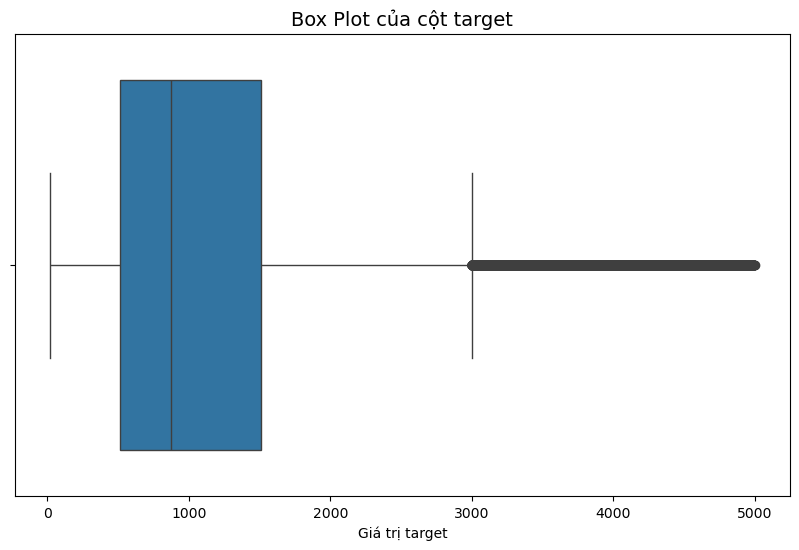

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train['target'])
plt.title("Box Plot của cột target", fontsize=14)
plt.xlabel("Giá trị target")
plt.show()

In [6]:
Q1 = train['target'].quantile(0.25)
Q3 = train['target'].quantile(0.75)
IQR = Q3 - Q1
train = train[(train['target'] >= Q1 - 1.5 * IQR) & (train['target'] <= Q3 + 1.5 * IQR)]

- Đối với ‘feature_12’ là ngày, tháng, năm nên ta sẽ chuyển sang định dạng datetime, sau đó trích xuất year, month, day và xóa cột `feature_12` gốc.
- Cột id trong train không có ý nghĩa huấn luyện nên loại bỏ cột id trong train.

In [7]:
train['feature_12'] = pd.to_datetime(train['feature_12'])

# Trích xuất đặc trưng
train['year'] = train['feature_12'].dt.year
train['month'] = train['feature_12'].dt.month
train['day'] = train['feature_12'].dt.day

# Xóa cột feature_12 gốc
train = train.drop(columns=['feature_12', 'id'], axis = 1)

- Bộ dữ liệu train sau khi thay đổi.

In [8]:
train.dtypes

Age           float64
Gender         object
feature_0     float64
feature_1      object
feature_2     float64
feature_3      object
feature_4      object
feature_5     float64
feature_6      object
feature_7      object
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_13     object
feature_14     object
feature_15     object
feature_16     object
target        float64
year            int64
month           int64
day             int64
dtype: object

### Xử lý dữ liệu bị thiếu

- Ta sẽ kiểm tra dữ liệu thiếu và giải quyết bằng cách điền trung vị thay vì trung bình để tránh ảnh hưởng của outlier: 
    - Đầu tiên ta sẽ duyệt qua các cột số trong bộ dữ liệu train, nếu có giá trị thiếu thì sẽ được thay thế bằng giá trị trung vị của chính cột đó.

In [9]:
numeric_cols = train.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    train[col].fillna(train[col].median(), inplace=True)

-	Đối với các cột có giá trị không phải là số thì khi có giá trị thiếu thì sẽ được thay thế bằng giá trị xuất hiện nhiều nhất (mode).

In [10]:
non_numeric_cols = train.select_dtypes(exclude=['number']).columns
for col in non_numeric_cols: 
    train[col].fillna(train[col].mode()[0], inplace=True)  

- Kiểm tra dữ liệu thiếu sau khi đã xử lý:

In [11]:
print(train.isna().sum())

Age           0
Gender        0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
target        0
year          0
month         0
day           0
dtype: int64


### Xử lý dữ liệu bị trùng lặp

In [12]:
train.duplicated().sum()

0

- Ta có thể thấy không có dữ liệu bị trùng lặp.

### Kiểm tra đa cộng tuyến

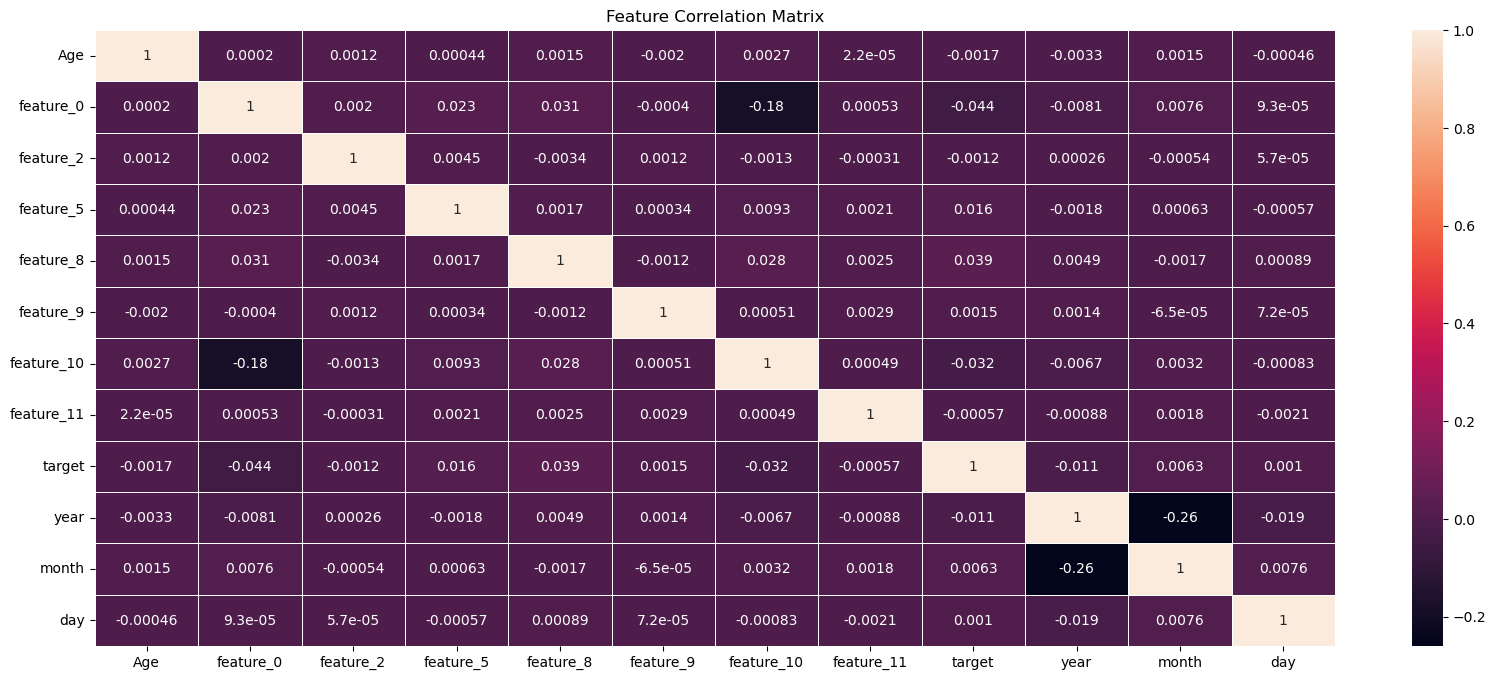

In [13]:
corr_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

- Không có cặp biến nào có tương quan tuyệt đối cao (|r| gần 1). Tất cả hệ số tương quan đều rất nhỏ, gần bằng 0.
- Một số giá trị lớn hơn về mặt tương đối (như giữa month và year có r xấp xỉ -0.26), nhưng vẫn không đáng kể để gây lo ngại về đa cộng tuyến.
- Nhìn chung, không phát hiện đa cộng tuyến rõ ràng từ heatmap.

In [14]:
numeric_cols = [col for col in numeric_cols if col != 'target']
X_vif = train[numeric_cols].copy()
X_vif = sm.add_constant(train[numeric_cols])
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data

,Feature,VIF
0,const,2.019613e+06
1,Age,1.000027e+00
2,feature_0,1.037600e+00
3,feature_2,1.000040e+00
4,feature_5,1.000760e+00
5,feature_8,1.002131e+00
6,feature_9,1.000018e+00
7,feature_10,1.036905e+00
8,feature_11,1.000028e+00
9,year,1.073004e+00


- Dựa trên kết quả VIF thì ta có thể thấy:
    - Tất cả các biến đều có VIF xấp xỉ 1, ngoại trừ const (mặc định cao do nó là hằng số). Điều này cho thấy không có đa cộng tuyến giữa các biến độc lập.

### Chuẩn hóa dữ liệu

-	Ta sẽ chuyển các giá trị không phải số trong bộ dữ liệu train, chuyển thành các cột nhị phân (0 hoặc 1), sử dụng `drop_first = True` để tránh hiện tượng đa cộng tuyến khi dùng trong các mô hình hồi quy.

In [15]:
train = pd.get_dummies(train, columns=non_numeric_cols, drop_first=True)

-	Sử dụng `StandardScaler()` từ thư viện `sklearn.preprocessing` để chuẩn hóa dữ liệu sao cho mỗi đặc trưng trong bộ dữ liệu có trung bình = 0 và độ lệch chuẩn = 1.

In [16]:
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])

- Sau khi chuẩn hóa xong thì ta sẽ xem xét về cột `target`

In [17]:
def plot_target_histogram(data, column='target', bins=50, log_transform=False):
    plt.figure(figsize=(8, 5))

    if log_transform:
        plt.hist(np.log1p(data[column]), bins=bins, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of log1p({column})')
        plt.xlabel(f'log1p({column})')
    else:
        plt.hist(data[column], bins=bins, color='lightgreen', edgecolor='black')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)

    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

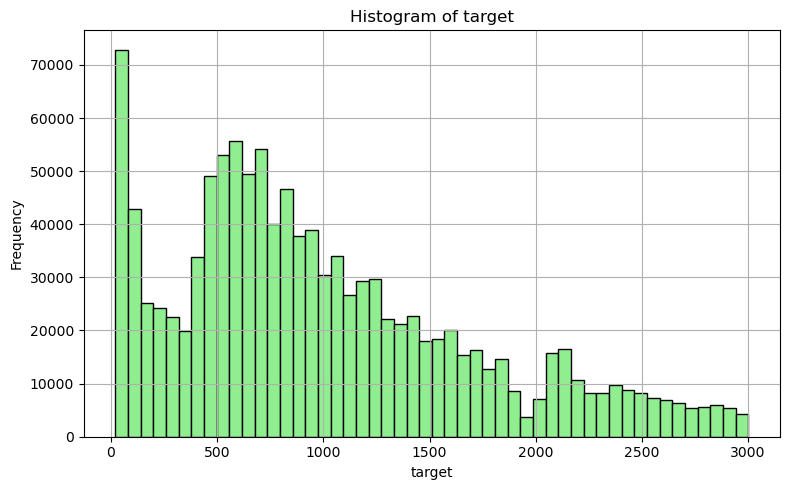

In [18]:
plot_target_histogram(train)

-	Ta có thể thấy phân phối `target` bị lệch phải, vì vậy ta sẽ chuẩn hóa logarit cho `target`

In [19]:
train['target'] = np.log1p(train['target'])

## Feature engineering

In [20]:
X = train.drop([ 'target'], axis=1)
y = train['target']

- Ta sẽ sử dụng LassoCV với cross-validation 5 lần để chọn các đặc trưng quan trọng cho mô hình hồi quy để dự đoán giá trị mục tiêu bằng cách giảm các hệ số của những đặc trung không quan trọng về 0, giúp mô hình tránh bị overfitting và chọn ra tham số điều chỉnh tốt.

In [21]:
lasso = LassoCV(cv=5)
lasso.fit(X, y)

selected = X.columns[lasso.coef_ != 0]
X = train[selected]
X

,Age,feature_0,feature_2,feature_5,feature_8,feature_9,feature_10,year,month,day,Gender_Male,feature_1_Single,feature_3_Master's,feature_6_Urban,feature_13_Good,feature_13_Poor,feature_15_Rarely,feature_15_Weekly,feature_16_Condo,feature_16_House
0,-1.648652,-0.705582,-0.746810,-0.249109,1.223657,1.286280,-1.566864,0.934695,1.605376,0.827512,0,0,0,1,0,1,0,1,0,1
1,-0.159967,-0.015502,0.733428,-0.844099,0.000920,0.420532,0.714985,0.934695,-0.142995,-0.420766,0,0,1,0,0,0,0,0,0,1
2,-1.350915,-0.209359,0.733428,1.831424,0.000920,0.766831,0.013423,0.934695,0.731190,1.621871,1,0,0,0,1,0,0,1,0,1
3,-1.499784,3.499730,-0.006691,-1.236151,0.000920,-1.657262,-1.602297,1.613037,-0.142995,-0.420766,1,0,0,0,0,1,0,0,0,0
4,-1.499784,0.238879,-0.746810,-0.437252,-1.221817,-0.272066,0.034682,-0.421990,1.605376,-1.669044,1,1,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,-0.383270,-0.154673,-1.486929,-0.996195,0.000920,-0.791515,-1.566864,0.934695,-0.434391,-1.442085,0,0,1,1,0,1,0,0,0,0
1199996,0.956547,0.115565,-0.006691,-1.189989,0.000920,0.074233,0.027596,0.256352,0.731190,-0.647726,1,0,1,0,0,1,0,1,0,0
1199997,-1.648652,0.629176,-1.486929,-0.915648,-1.221817,1.632579,0.013423,-0.421990,-0.434391,1.054472,1,0,1,0,1,0,0,0,1,0
1199998,1.030981,-0.264906,-0.746810,-0.592048,0.000920,-0.445216,-1.318837,-0.421990,0.731190,0.373593,1,1,0,0,0,1,0,0,0,0


## Xây dựng model

-	Ta sẽ tiến hành chia bộ dữ liệu thành 3 phần: 70% train - 20% validation - 10% test

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

### Lựa chọn mô hình: XGBoost

### Lý do lựa chọn mô hình XGBoost

### Thiết kế kiến trúc

- Dể đảm bảo tính tái lập của kết quả bằng cách thiết lập giá trị seed cho các thư viện cần thiết.
- Dữ liệu huấn luyện và validation được chuyển thành DMatrix, định dạng đặc biệt của XGBoost.
- Các tham số huấn luyện được thiết lập theo thiết kế phía trên.
- Mô hình XGBoost được huấn luyện qua 5000 vòng lặp với kiểm tra sớm và dừng nếu không có cải thiện trong 50 vòng.

In [23]:
seed = 42
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.001,
    'max_depth': 10,
    'min_child_weight': 5,
    'subsample': 0.9,
    'colsample_bytree': 0.85,
    'gamma': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'eval_metric': 'rmse',
    'seed': seed,
    'tree_method': 'hist',
    'max_bin': 512
}

start_time = time.time()
tracemalloc.start()

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=50
)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
xgb_mem_peak = peak / (1024 ** 2)
xgb_time = end_time - start_time


[0]	train-rmse:1.06782	val-rmse:1.06835
[50]	train-rmse:1.06381	val-rmse:1.06472
[100]	train-rmse:1.06004	val-rmse:1.06131
[150]	train-rmse:1.05651	val-rmse:1.05816
[200]	train-rmse:1.05300	val-rmse:1.05501
[250]	train-rmse:1.04974	val-rmse:1.05212
[300]	train-rmse:1.04687	val-rmse:1.04960
[350]	train-rmse:1.04412	val-rmse:1.04721
[400]	train-rmse:1.04148	val-rmse:1.04493
[450]	train-rmse:1.03915	val-rmse:1.04296
[500]	train-rmse:1.03705	val-rmse:1.04119
[550]	train-rmse:1.03494	val-rmse:1.03943
[600]	train-rmse:1.03298	val-rmse:1.03780
[650]	train-rmse:1.03113	val-rmse:1.03629
[700]	train-rmse:1.02928	val-rmse:1.03479
[750]	train-rmse:1.02755	val-rmse:1.03339
[800]	train-rmse:1.02601	val-rmse:1.03219
[850]	train-rmse:1.02452	val-rmse:1.03103
[900]	train-rmse:1.02330	val-rmse:1.03012
[950]	train-rmse:1.02209	val-rmse:1.02922
[1000]	train-rmse:1.02083	val-rmse:1.02829
[1050]	train-rmse:1.01977	val-rmse:1.02754
[1100]	train-rmse:1.01866	val-rmse:1.02675
[1150]	train-rmse:1.01763	val-rmse

In [ ]:
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = model.predict(dtest, iteration_range=(0, model.best_iteration))

y_pred = np.maximum(y_pred, 0)
y_test = np.maximum(y_test, 0)

# MSE 
mse_xgb = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))

# RMSLE
rmsle_xgb = np.sqrt(np.mean(np.square(np.log1p(np.expm1(y_test)) - np.log1p(np.expm1(y_pred)))))

# MAPE
mape_xgb = np.mean(np.abs((np.expm1(y_test) - np.expm1(y_pred)) / (np.expm1(y_test) + 1e-9))) * 100

print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2f}%")
print(f"Root Mean Squared Log Error (RMSLE): {rmsle_xgb:.4f}")

Mean Squared Error (MSE): 576535.6641
Mean Absolute Percentage Error (MAPE): 174.77%
Root Mean Squared Log Error (RMSLE): 1.0175


In [25]:
print(f"\nTổng thời gian huấn luyện: {end_time - start_time:.2f} giây")
print(f"Bộ nhớ RAM peak trong quá trình huấn luyện: {peak / (1024 ** 2):.2f} MB")


Tổng thời gian huấn luyện: 914.12 giây
Bộ nhớ RAM peak trong quá trình huấn luyện: 254.37 MB


### Nhận xét

**1. Mean Squared Error (MSE): 576,527.04**
- Đây là sai số bình phương trung bình rất lớn, cho thấy mô hình dự đoán còn kém chính xác, đặc biệt là với các giá trị lớn.
- Do MSE phạt mạnh những sai số lớn, điều này có thể là dấu hiệu của việc mô hình bị ảnh hưởng bởi các outlier hoặc dự đoán sai lệch nghiêm trọng trên một số điểm.

**2. R² Score: -0.1419**
- Giá trị R² âm cho thấy mô hình hoạt động **tệ hơn việc chỉ dùng trung bình cộng để dự đoán**.
- Điều này là tín hiệu nghiêm trọng: mô hình hiện tại không học được mối quan hệ nào có ích từ dữ liệu.
- Có thể do:
     - Dữ liệu chưa được xử lý tốt.
     - Mô hình quá đơn giản, hoặc siêu tham số chưa phù hợp.

**3. Mean Absolute Percentage Error (MAPE): 174.73%**
- Đây là một mức MAPE rất cao, tức là trung bình mỗi dự đoán lệch đến gần 175% so với giá trị thực.
- Giá trị cao như vậy thường là dấu hiệu:
     - Tồn tại nhiều giá trị mục tiêu nhỏ (MAPE dễ bị tăng mạnh khi chia cho giá trị nhỏ).
     - Mô hình có khả năng dự đoán sai nghiêm trọng trên nhiều mẫu.

**4. Root Mean Squared Log Error (RMSLE): 1.0175**
- RMSLE đo sai số trên thang log, giúp giảm ảnh hưởng của outliers.
- Giá trị ~1 cho thấy dự đoán kém ổn định, đặc biệt trên các giá trị nhỏ.
- RMSLE thường hữu ích trong bài toán mà giá trị mục tiêu có phân phối lệch hoặc có chênh lệch lớn.

### Lựa chọn mô hình: LightGBM

- Dể đảm bảo tính tái lập của kết quả bằng cách thiết lập giá trị seed cho các thư viện cần thiết.
- Tạo tập huấn luyện và validation với lgb.Dataset, dùng reference=train_data để tối ưu hóa việc chia cây.
- Các tham số huấn luyện được thiết lập theo thiết kế phía trên.
- Mô hình XGBoost được huấn luyện qua 5000 vòng lặp với kiểm tra sớm và dừng nếu không có cải thiện trong 50 vòng.

In [26]:
seed = 42
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1', 'l2'],
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.85,
    'bagging_freq': 10,
    'verbose': 0,
    'max_depth': 10,
    'num_leaves': 96,
    'max_bin': 512,
    'seed': seed,
    'deterministic': True
}

start_time = time.time()
tracemalloc.start()

model = lgb.train(
    hyper_params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'val'],
    num_boost_round=5000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
lgb_mem_peak = peak / (1024 ** 2)
lgb_time = end_time - start_time


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[5000]	train's l1: 0.713217	train's l2: 1.01704	val's l1: 0.717234	val's l2: 1.03113


In [ ]:
y_pred = model.predict(X_test)

y_pred = np.maximum(y_pred, 0)
y_test = np.maximum(y_test, 0)

# MSE 
mse_lgbm = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))

# RMSLE
rmsle_lgbm = np.sqrt(np.mean(np.square(np.log1p(np.expm1(y_test)) - np.log1p(np.expm1(y_pred)))))

# MAPE
mape_lgbm = np.mean(np.abs((np.expm1(y_test) - np.expm1(y_pred)) / (np.expm1(y_test) + 1e-9))) * 100  

print(f"Mean Squared Error (MSE): {mse_lgbm:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lgbm:.2f}%")
print(f"Root Mean Squared Log Error (RMSLE): {rmsle_lgbm:.4f}")

Mean Squared Error (MSE): 576423.0700
Mean Absolute Percentage Error (MAPE): 174.89%
Root Mean Squared Log Error (RMSLE): 1.0174


In [28]:
print(f"\nTổng thời gian huấn luyện: {end_time - start_time:.2f} giây")
print(f"Bộ nhớ RAM peak trong quá trình huấn luyện: {peak / (1024 ** 2):.2f} MB")


Tổng thời gian huấn luyện: 397.92 giây
Bộ nhớ RAM peak trong quá trình huấn luyện: 135.97 MB


### So sánh thời gian chạy và bộ nhớ sử dụng của 2 model

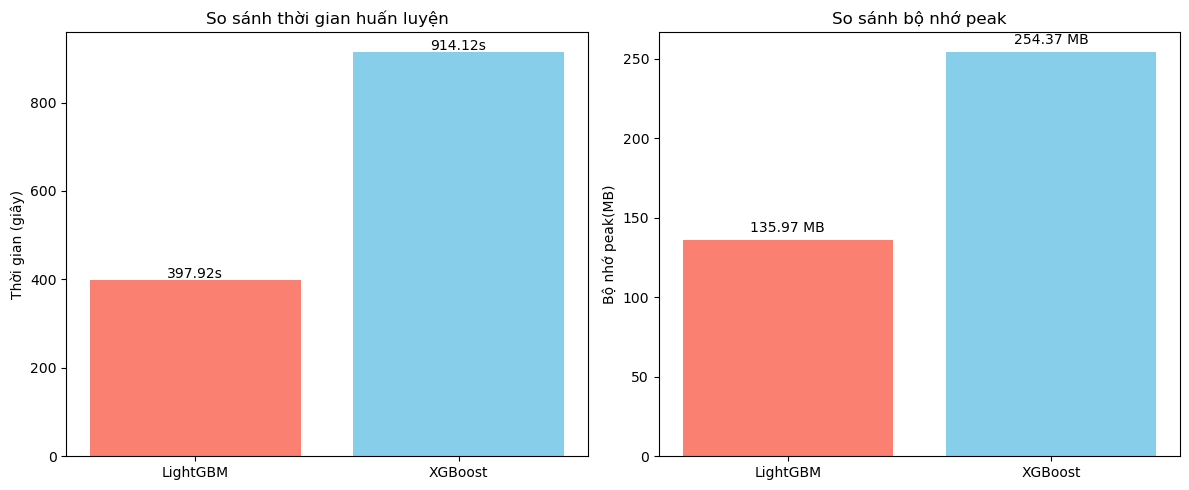

In [29]:
models = ['LightGBM', 'XGBoost']
memories = [lgb_mem_peak, xgb_mem_peak]
times = [lgb_time, xgb_time]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars1 = plt.bar(models, times, color=['salmon', 'skyblue'])
plt.ylabel('Thời gian (giây)')
plt.title('So sánh thời gian huấn luyện')
for bar, time_val in zip(bars1, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f"{time_val:.2f}s", ha='center')
    
plt.subplot(1, 2, 2)
bars2 = plt.bar(models, memories, color=['salmon', 'skyblue'])
plt.ylabel('Bộ nhớ peak(MB)')
plt.title('So sánh bộ nhớ peak')
for bar, mem_val in zip(bars2, memories):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f"{mem_val:.2f} MB", ha='center')

plt.tight_layout()
plt.show()